In [4]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [5]:
evds=evdsAPI('dsIC3fiGlu')


In [6]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4651,30-11-2023,28.9116
4652,01-12-2023,28.8728
4653,04-12-2023,28.9073
4654,05-12-2023,28.9035


In [7]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [8]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


In [9]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [10]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


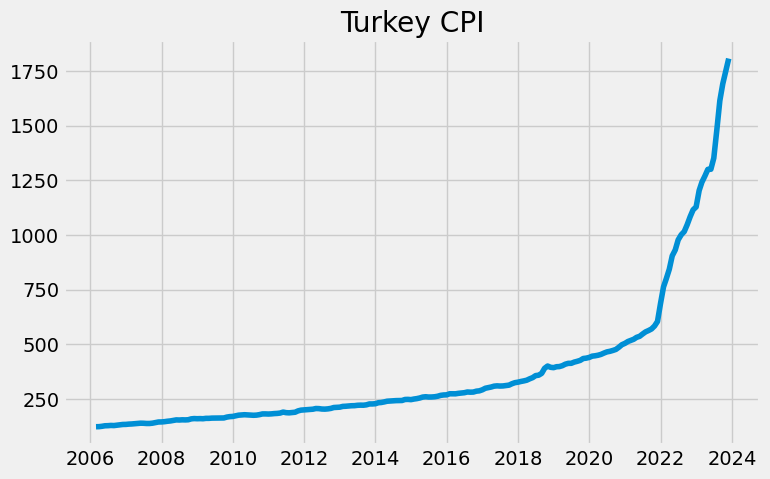

In [11]:
dates=pd.date_range('2006-02-01','2023-12-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [12]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [13]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637895


In [14]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933903


In [15]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-10-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-05-31,9.5
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.2


In [16]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-08-31,85.104348
2023-09-30,92.766499
2023-10-31,88.704091


In [17]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10


In [18]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503


In [19]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503


In [20]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
210,2023-8,23.50
211,2023-9,31.00
212,2023-10,33.00
213,2023-11,41.09


In [21]:
dates=pd.date_range('2006-02-28','2024-01-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00


In [22]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500
2023-10-31,59.3925


In [23]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100) (2).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-10-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-05-31,181.176925,179.718446,179.734862
2023-06-30,180.070938,186.170934,179.520633
2023-07-31,191.652101,194.140963,184.782561
2023-08-31,184.907520,183.148681,176.126980


In [24]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-12-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [25]:
sanayi=pd.read_excel("C:/Users/Bora/Downloads/sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-05-31,146.666835
2023-06-30,148.351267
2023-07-31,147.798299
2023-08-31,146.674452


In [26]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-12-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560
2023-10-31,43.8925


In [27]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-12-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57


In [28]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",end="2023-11-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09


In [29]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-12-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-07-31,81.62
2023-08-31,85.39
2023-09-30,89.35
2023-10-31,89.16


In [30]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-12-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-07-31,48.71
2023-08-31,52.42
2023-09-30,55.55
2023-10-31,56.01


In [31]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"][:-1].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["Borç"]=(borc["Borç"]/1e+08).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USD/TL,ParaArzi,Motorin,Perakende Satış,Sanayi,Kredi,M3,Borç,TÜFE
Tarih,,,,,,,,,
2010-02-28,0.574311,-0.468328,-0.470323,0.935668,2.358713,2.473323,-0.317515,1.774400,1.447693
2010-03-31,0.644001,1.850070,2.622296,1.971218,1.929881,2.894349,1.831928,1.064192,0.583272
2010-04-30,0.478728,1.038067,0.713406,0.918462,1.021775,3.033220,0.969354,0.366513,0.596780
2010-05-31,0.646630,0.240025,-0.856462,0.610769,2.763430,3.592510,0.095471,0.729264,-0.358182
2010-06-30,0.922501,1.537408,-0.175370,-0.094972,0.563442,3.358199,1.609402,-0.769974,-0.561672
...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.931099,-0.372743,5.675617,15.439600,9.689321,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.684198,-0.760392,1.850455,5.968276,2.618269,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.712124,-0.125062,2.080815,4.845313,4.384930,4.753114


In [32]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data=data.dropna(axis=0)
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,9.0220,91.32,95.75,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.6275,93.31,96.63,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.3125,93.75,97.25,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,11.0200,98.14,102.98,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.4940,99.40,105.10,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.507585,-7.526882,3.200118,32.0225,0.00,1.434427,7.37,4.931112,2.663712,3.535416,31.4625,94.53,57.99,4.796282,9.5,9.09,0.043076
2023-06-30,7.066073,16.807611,-0.119192,38.5600,0.00,1.148476,7.55,-1.017069,2.406884,5.711697,39.5920,87.02,51.59,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.931099,45.8250,34.00,-0.372743,7.70,15.146856,9.689321,5.675617,33.1250,81.62,48.71,15.439600,9.3,17.50,9.488824


In [33]:
features=["USD/TL","Motorin","Enflasyon Belirsizliği","ParaArzi","Kredi Faizi","TÜFE"]
train=data[features].iloc[:-3,:]
test=data[features].iloc[-3:,:]


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [35]:
test_period = 3 # Son 3 ayı test olarak ayırın
test_size = test_period   # Her ay 30 gün olarak kabul ederek hesaplayın

train_data = data[:-test_size]
test_data = data[-test_size:]

# Bağımsız değişkenleri ve TÜFE'yi ayırın
X_train = train.drop(['TÜFE'], axis=1).values
y_train = train['TÜFE'].values
X_test = test.drop(['TÜFE'], axis=1).values
y_test = test['TÜFE'].values

In [36]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

In [37]:
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(X_train_scaled.shape[1],1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu')) # 1, çünkü tek bir özellik kullanıyoruz
model.add(tf.keras.layers.Dense(1))
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')


early_stopping = EarlyStopping(patience=25, restore_best_weights=True)

model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])


Epoch 1/500
4/4 [==============================] - 2s 113ms/step - loss: 2.5249 - val_loss: 0.6389
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0783 - val_loss: 0.2019
Epoch 3/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0190 - val_loss: 0.1455
Epoch 4/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0182 - val_loss: 0.1247
Epoch 5/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0172 - val_loss: 0.1310
Epoch 6/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0166 - val_loss: 0.1219
Epoch 7/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0145 - val_loss: 0.0860
Epoch 8/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0130 - val_loss: 0.0659
Epoch 9/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0188 - val_loss: 0.2537
Epoch 10/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0498 - val_loss: 0.0921
Epoch 11/500
4/4 [

In [38]:
'''import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ParameterGrid

# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)

# Model fonksiyonunu tanımlayın
def create_model(neurons=128, activation='relu', optimizer='adam', epochs=100):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])
    return model


# Grid Search için hiperparametre kombinasyonlarını tanımlayın
param_grid = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh','selu','sigmoid','elu','gelu','linear'],
    'optimizer': ['adam', 'rmsprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl'],
    'epochs': [500]
}

best_rmse = float('inf')
best_params = None

# Grid Search yapın
for params in ParameterGrid(param_grid):
    model = create_model(neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], epochs=params['epochs'])
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# En iyi hiperparametreleri ve sonuçları görüntüleyin
print("En iyi RMSE:", best_rmse)
print("En iyi parametreler:", best_params)'''


'import numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nfrom sklearn.metrics import make_scorer, mean_squared_error\nfrom sklearn.model_selection import ParameterGrid\n\n# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)\n\n# Model fonksiyonunu tanımlayın\ndef create_model(neurons=128, activation=\'relu\', optimizer=\'adam\', epochs=100):\n    model = Sequential()\n    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))\n    model.add(Dense(1))\n    model.compile(optimizer=optimizer, loss=\'mean_squared_error\')\n    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)\n    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])\n    return model\n\n\n# Grid Search için hiperparametre kombinasyonlarını tanımlayın\nparam_grid = {\n    \'neurons\'

In [39]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Modelinizi eğittikten sonra tahminlerinizi yapın
y_pred = model.predict(X_test_scaled)

# Tahminleri gerçek değerlerle karşılaştırarak MSE hesaplayın
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


1/1 [==============================] - 0s 236ms/step
Validation MSE: 0.002536356502214066
Validation RMSE: 0.050362252751580384


In [40]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

# Tahmin edilen değerleri inceleyin
np.sqrt(mean_squared_error(y_test,y_pred_original_scale))

0.7563609206232158

In [41]:
cor_matrix=data.corr()
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.724721
Motorin                   0.718312
ParaArzi                  0.678612
M3                        0.670119
Enflasyon Belirsizliği    0.622137
Kredi Faizi               0.531337
Kredi                     0.520359
Borç                      0.447182
Mevduat Faizi             0.441591
Zam                       0.410035
Politika Faizi            0.215310
Sanayi                   -0.047965
Perakende Satış          -0.116436
İşsizlik                 -0.187390
REDK                     -0.391061
REDKT                    -0.575371
Name: TÜFE, dtype: float64

In [42]:
data.to_csv("data.csv")

In [44]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=data.iloc[:,:-1].columns
train=data.iloc[:-3,:]
test=data.iloc[-3:,:]
X_train,X_test,y_train,y_test=train.iloc[:,:-1],test.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,-1]
best_mse=float("inf")
best_features=[]
for r in range(8,12):
   for combo in combinations(features, r):
        selected_features = list(combo)
        
          
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train_subset, y_train)
        y_pred=krr.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)

KeyboardInterrupt: 

In [45]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Sanayi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X = sm.add_constant(X)
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model = sm.OLS(y, X).fit()
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [46]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [47]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [48]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Sanayi', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [49]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [50]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [51]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [52]:
tahminler["LSTM"]=y_pred_original_scale
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred_original_scale)))

In [53]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Gaussian Regression,0.009468
Kernel Regression,0.009569
Linear Regression,0.137010
Lars Regression,0.140347
SGD Regressor,0.282917
Lasso Regression,0.285653
Bayesian Regression,0.412193
LSTM,0.756361


In [54]:
tahminler.index.strftime("%Y-%m")

Index(['2023-07', '2023-08', '2023-09'], dtype='object', name='Tarih')

In [55]:
tahminler=tahminler.set_index(pd.date_range(start="2023-07",periods=3,freq="M"))
tahminler.index=tahminler.index.strftime("%Y-%m")


<Axes: >

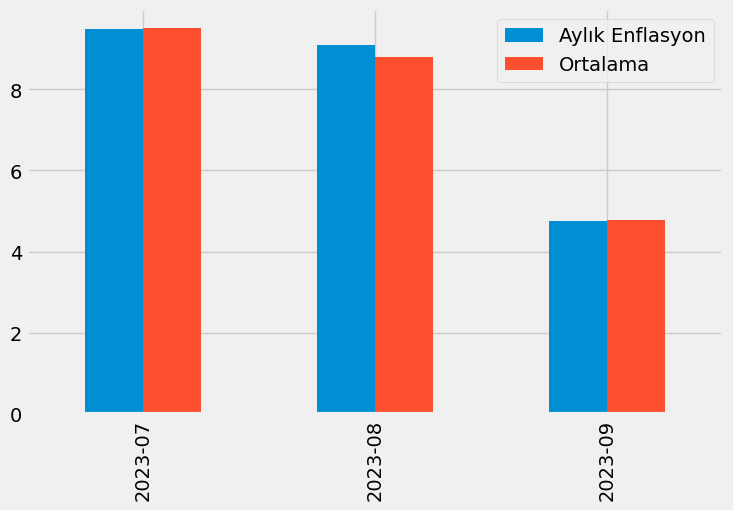

In [56]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Ortalama"]].plot(kind="bar",figsize=(8,5))

In [57]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(13)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-01-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40]
faiztahmin

,Politika Faizi
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,45.00
2024-02-29,45.00
2024-03-31,45.00
2024-04-30,45.00
2024-05-31,45.00


In [58]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,58.050804
2024-01-31,58.243736
2024-02-29,58.551302
2024-03-31,59.409785
2024-04-30,60.386403
2024-05-31,60.370085


In [59]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.7920
2010-02-28,13.5200
2010-03-31,13.5125
2010-04-30,13.0040
2010-05-31,13.1525
...,...
2023-05-31,32.0225
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650


In [60]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,58.050804
2024-01-31,58.243736
2024-02-29,58.551302
2024-03-31,59.409785
2024-04-30,60.386403
2024-05-31,60.370085
2024-06-30,61.813906
2024-07-31,62.228177


In [61]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz[:-1],trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(14,X=faiztahmin[4:]))
mfaiztahmin.columns=["Mevduat Faizi"]
#row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-1,0]},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
#mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2023-12-31,47.851478
2024-01-31,48.648966
2024-02-29,48.171069
2024-03-31,48.461808
2024-04-30,48.499189
2024-05-31,48.379245
2024-06-30,48.420419
2024-07-31,48.444226
2024-08-31,48.418841
2024-09-30,48.421924


In [62]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [63]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-08-31,2275.241982
2023-09-30,2504.165548
2023-10-31,2432.069312
2023-11-30,2316.594077


In [64]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,45
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [65]:
faiztahmin.columns=["Faiz"]


In [66]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [67]:
exog=pfaiz["Politika Faizi"].iloc[95:-3]
exog=np.array(exog).reshape(-1,1)

In [68]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [69]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(16,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-10-31,9.086846
2023-11-30,9.020789
2023-12-31,9.050290
2024-01-31,9.065341
2024-02-29,9.121499
2024-03-31,9.176342
2024-04-30,9.229218
2024-05-31,9.281954
2024-06-30,9.332391
2024-07-31,9.380442


In [70]:
from prophet import Prophet


In [72]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'm':trial.suggest_int('m',10,200)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6[params["m"]:-12].index
    sn["y"]=df6[params["m"]:-12].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth="linear")
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df6[-12:].values,predictions["yhat"][-12:].values)
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'m\':trial.suggest_int(\'m\',10,200)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6[params["m"]:-12].index\n    sn["y"]=df6[params["m"]:-12].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth="linear")\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=12,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(df6[-12:].values,predictions["yhat"][-12:].values)\n    return mae_score\nstudy = optuna.crea

In [ ]:
#study.best_params

{'changepoint_prior_scale': 0.11536391378251662,
 'changepoint_range': 0.8994927602873863,
 'growth': 'linear',
 'm': 25}

In [73]:
sn=pd.DataFrame()
sn["ds"]=df6[25:].index
sn["y"]=df6[25:].values
sn["cap"]=80
prophet=Prophet(growth="logistic",changepoint_prior_scale=0.11536391378251662,changepoint_range=0.8994927602873863)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=80
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:15 - cmdstanpy - INFO - Chain [1] start processing
23:07:15 - cmdstanpy - INFO - Chain [1] done processing


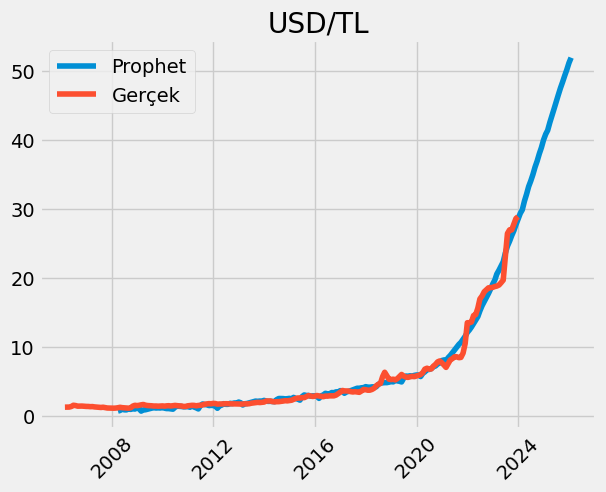

In [74]:
plt.title("USD/TL")
plt.plot(predictions["yhat"],label="Prophet")
plt.plot(df6["USD/TL"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [75]:
usdtahmin=(predictions["yhat"][-26:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-01-31    2.801453
2024-02-29    1.751956
2024-03-31    4.216599
2024-04-30    3.151839
2024-05-31    3.541972
2024-06-30    2.404068
2024-07-31    2.743816
2024-08-31    3.105584
2024-09-30    2.386920
2024-10-31    2.866109
2024-11-30    2.324531
2024-12-31    2.872616
2025-01-31    2.097923
2025-02-28    1.324741
2025-03-31    2.743055
2025-04-30    2.231028
2025-05-31    2.375120
2025-06-30    2.253383
2025-07-31    2.228925
2025-08-31    2.135922
2025-09-30    1.789650
2025-10-31    1.940928
2025-11-30    1.734907
2025-12-31    1.966982
2026-01-31    1.502411
Name: yhat, dtype: float64

In [76]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-5:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", end="2026-02-27", freq="1M"))
usdtahmin1

,USD/TL
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,28.901525
2024-01-31,29.711188
2024-02-29,30.231715
2024-03-31,31.506465
2024-04-30,32.499498
2024-05-31,33.650621


In [77]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[100:].index
    sn["y"]=df14[100:].values
    sn["cap"]=1000
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=1000
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[100:].index\n    sn["y"]=df14[100:].values\n    sn["cap"]=1000\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=1000\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [78]:
#study.best_params

In [79]:
sn=pd.DataFrame()
sn["ds"]=df14[100:].index
sn["y"]=df14[100:].values
sn["cap"]=500
prophet=Prophet(growth="linear",changepoint_prior_scale=4.999468721964881,changepoint_range=0.8755786334851338)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=500
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:16 - cmdstanpy - INFO - Chain [1] start processing
23:07:16 - cmdstanpy - INFO - Chain [1] done processing


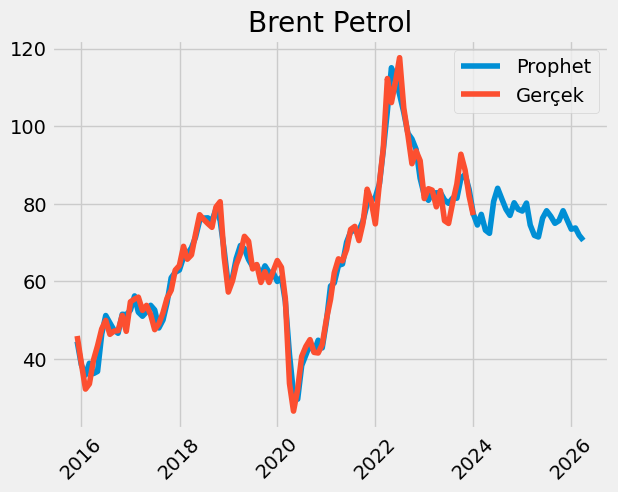

In [80]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"],label="Prophet")
plt.plot(df14["Brent"][100:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [81]:
brenttahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
brenttahmin

ds
2024-01-31    -3.766855
2024-02-29     3.678078
2024-03-31    -5.269168
2024-04-30    -1.114076
2024-05-31    11.332271
2024-06-30     4.234463
2024-07-31    -3.245776
2024-08-31    -3.284210
2024-09-30    -2.041721
2024-10-31     4.242047
2024-11-30    -2.087258
2024-12-31    -0.583713
2025-01-31     2.626344
2025-02-28    -7.052924
2025-03-31    -3.590205
2025-04-30    -0.576636
2025-05-31     6.808836
2025-06-30     2.494416
2025-07-31    -1.832080
2025-08-31    -2.352461
2025-09-30     0.894328
2025-10-31     3.405763
2025-11-30    -3.018101
2025-12-31    -3.167875
2026-01-31     0.424535
2026-02-28    -2.563270
2026-03-31    -1.849038
Name: yhat, dtype: float64

In [82]:
df14.iloc[-1]

Brent    77.084999
Name: 2023-12-31 00:00:00, dtype: float64

In [83]:
brenttahmin1 = []
result = df14.iloc[-1,0]
for i in range(len(brenttahmin)):
    result *= (1 + brenttahmin[i] / 100)
    brenttahmin1.append(result)

brenttahmin1 = np.array(brenttahmin1).reshape(-1, 1)
brenttahmin1 = pd.DataFrame(brenttahmin1)
brenttahmin1.columns = ["Brent"]
brenttahmin1 = brenttahmin1.set_index(pd.date_range(start="2024-01-30", end="2026-04-27", freq="1M"))
row=pd.DataFrame({"Brent":df14.iloc[-3:,0]},index=pd.date_range("2023-10-30",periods=3,freq="1M"))
brenttahmin1=pd.concat([row,brenttahmin1],axis=0)
brenttahmin1

,Brent
2023-10-31,88.704091
2023-11-30,82.027727
2023-12-31,77.084999
2024-01-31,74.181319
2024-02-29,76.909766
2024-03-31,72.857261
2024-04-30,72.045575
2024-05-31,80.209975
2024-06-30,83.606437
2024-07-31,80.892759


In [84]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [85]:
#study.best_params

In [86]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=4.9990034924644275,changepoint_range=0.899334568997575,growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:16 - cmdstanpy - INFO - Chain [1] start processing
23:07:16 - cmdstanpy - INFO - Chain [1] done processing


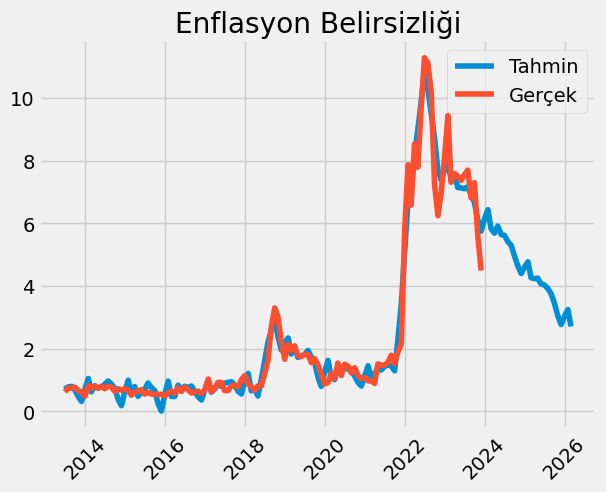

In [87]:
plt.title("Enflasyon Belirsizliği")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(enf_belirsizlik["Enflasyon Belirsizliği"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [88]:
enfbelirsizliktahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
enfbelirsizliktahmin

ds
2023-12-31     6.953347
2024-01-31     4.726997
2024-02-29    -9.552151
2024-03-31    -2.312712
2024-04-30     4.034606
2024-05-31    -4.604811
2024-06-30    -0.478931
2024-07-31    -3.538186
2024-08-31    -2.265246
2024-09-30    -6.425931
2024-10-31    -6.548229
2024-11-30    -5.019494
2024-12-31     4.654556
2025-01-31     3.666030
2025-02-28   -10.624290
2025-03-31    -0.724876
2025-04-30     0.362321
2025-05-31    -4.422187
2025-06-30    -0.710613
2025-07-31    -2.719679
2025-08-31    -4.438113
2025-09-30    -8.031677
2025-10-31   -11.645712
2025-11-30    -9.110944
2025-12-31     9.693603
2026-01-31     6.928056
2026-02-28   -16.593937
Name: yhat, dtype: float64

In [89]:
enfbelirsizliktahmin1 = []
result = enf_belirsizlik.iloc[-1,0]
for i in range(len(enfbelirsizliktahmin)):
    result *= (1 + enfbelirsizliktahmin[i] / 100)
    enfbelirsizliktahmin1.append(result)

enfbelirsizliktahmin1 = np.array(enfbelirsizliktahmin1).reshape(-1, 1)
enfbelirsizliktahmin1 = pd.DataFrame(enfbelirsizliktahmin1)
enfbelirsizliktahmin1.columns = ["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1 = enfbelirsizliktahmin1.set_index(pd.date_range(start="2023-12-30", end="2026-03-27", freq="1M"))
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
enfbelirsizliktahmin1=pd.concat([row,enfbelirsizliktahmin1],axis=0)
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
2023-10-31,5.570000
2023-11-30,4.490000
2023-12-31,4.802205
2024-01-31,5.029205
2024-02-29,4.548808
2024-03-31,4.443607
2024-04-30,4.622889
2024-05-31,4.410014
2024-06-30,4.388893
2024-07-31,4.233606


In [90]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=51,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].index\n    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=51,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nst

In [91]:
#study.best_params

In [92]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][100:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][100:].values
sn["cap"]=1000
prophet=Prophet(changepoint_prior_scale=4.9993655900615845,changepoint_range=0.8731420056547374,growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=1000
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:17 - cmdstanpy - INFO - Chain [1] start processing
23:07:17 - cmdstanpy - INFO - Chain [1] done processing


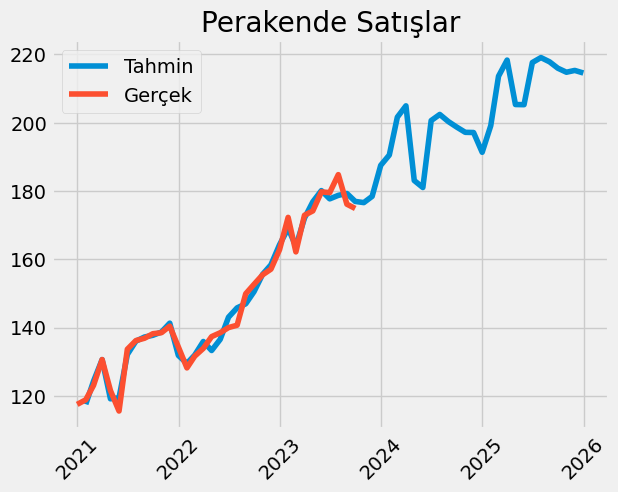

In [93]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-60:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][131:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [94]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2023-10-31    -0.198150
2023-11-30     1.033406
2023-12-31     5.092513
2024-01-31     1.614187
2024-02-29     5.821133
2024-03-31     1.644104
2024-04-30   -10.673696
2024-05-31    -1.121014
2024-06-30    10.832184
2024-07-31     0.895907
2024-08-31    -1.028484
2024-09-30    -0.804435
2024-10-31    -0.776320
2024-11-30    -0.028461
2024-12-31    -2.934550
2025-01-31     4.074081
2025-02-28     7.271980
2025-03-31     2.211173
2025-04-30    -5.961543
2025-05-31    -0.023782
2025-06-30     6.015436
2025-07-31     0.667099
2025-08-31    -0.566781
2025-09-30    -0.861429
2025-10-31    -0.543977
2025-11-30     0.246907
2025-12-31    -0.349946
Name: yhat, dtype: float64

In [95]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-2].pct_change(periods=1)*100).dropna())/100)).values)
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-11-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-5.157893
2024-01-31,-1.070929
2024-02-29,5.494473
2024-03-31,-1.274749
2024-04-30,2.002649
2024-05-31,15.275630
2024-06-30,6.740330
2024-07-31,-0.591019
2024-08-31,-0.280619


In [96]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=51,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=51,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [97]:
#study.best_params

In [98]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=4.465458778605585,
 changepoint_range=0.8996787920607507,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:18 - cmdstanpy - INFO - Chain [1] start processing


23:07:18 - cmdstanpy - INFO - Chain [1] done processing


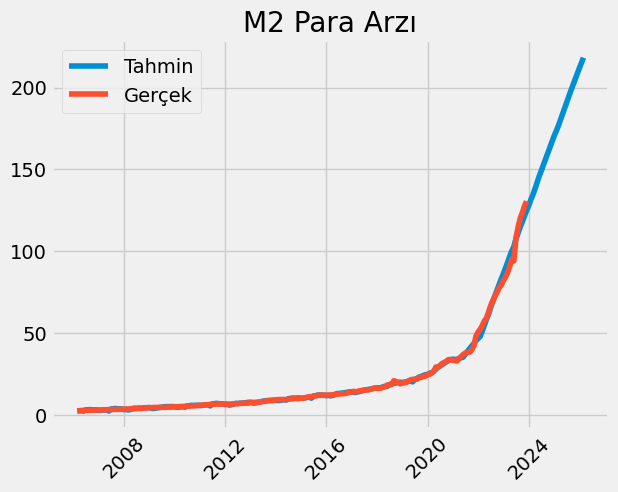

In [99]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(money["Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [100]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(30)
paraarzitahmin

ds
2023-09-30    2.742927
2023-10-31    2.940250
2023-11-30    2.726425
2023-12-31    2.435868
2024-01-31    2.899538
2024-02-29    2.177861
2024-03-31    2.761391
2024-04-30    2.752941
2024-05-31    2.824177
2024-06-30    2.229595
2024-07-31    2.454751
2024-08-31    2.258201
2024-09-30    2.225370
2024-10-31    2.226802
2024-11-30    2.154542
2024-12-31    2.101143
2025-01-31    1.773219
2025-02-28    1.700967
2025-03-31    2.101302
2025-04-30    2.026967
2025-05-31    1.966452
2025-06-30    1.982971
2025-07-31    1.901343
2025-08-31    1.827956
2025-09-30    1.701544
2025-10-31    1.750731
2025-11-30    1.682076
2025-12-31    1.604009
2026-01-31    1.531496
2026-02-28    1.445728
Name: yhat, dtype: float64

In [101]:
paraarzitahmin1 = []
result = money.iloc[-4,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2023-09-30", end="2026-03-27", freq="1M"))
paraarzitahmin1.iloc[:2,0]=money.iloc[-3:-1,0]
paraarzitahmin1

,Para Arzi
2023-09-30,123.493114
2023-10-31,127.637895
2023-11-30,130.651971
2023-12-31,133.834480
2024-01-31,137.715062
2024-02-29,140.714305
2024-03-31,144.599977
2024-04-30,148.580730
2024-05-31,152.776912
2024-06-30,156.183219


In [102]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"].index
    sn["y"]=borc["Borç"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"].index\n    sn["y"]=borc["Borç"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [103]:
#study.best_params

In [104]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"].index
sn["y"]=borc["Borç"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=6.640430210557363,
 changepoint_range=0.9191998720423614,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:19 - cmdstanpy - INFO - Chain [1] start processing


23:07:19 - cmdstanpy - INFO - Chain [1] done processing


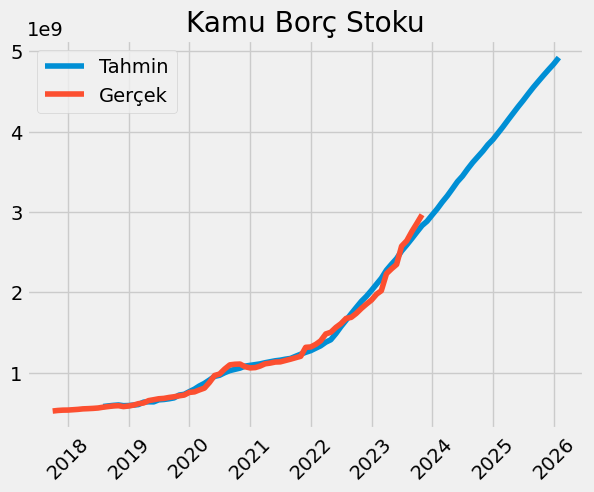

In [105]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][150:],label="Tahmin")
plt.plot(borc["Borç"][140:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [106]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(27)
borctahmin

ds
2023-11-30    1.883543
2023-12-31    2.736763
2024-01-31    2.617891
2024-02-29    2.666241
2024-03-31    2.527586
2024-04-30    2.671336
2024-05-31    2.764717
2024-06-30    2.029508
2024-07-31    2.563505
2024-08-31    2.324508
2024-09-30    1.934602
2024-10-31    1.944401
2024-11-30    2.097859
2024-12-31    1.723105
2025-01-31    2.081369
2025-02-28    1.846078
2025-03-31    2.130799
2025-04-30    1.968873
2025-05-31    1.988258
2025-06-30    1.787297
2025-07-31    1.919915
2025-08-31    1.820722
2025-09-30    1.612128
2025-10-31    1.617475
2025-11-30    1.496293
2025-12-31    1.473541
2026-01-31    1.653247
Name: yhat, dtype: float64

In [107]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-11-30", end="2026-02-27", freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-07-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.022643e+09
2023-12-31,3.105365e+09
2024-01-31,3.186661e+09
2024-02-29,3.271625e+09
2024-03-31,3.354318e+09
2024-04-30,3.443923e+09


In [108]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [109]:
#study.best_params

In [110]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"].index
sn["y"]=df3["Kredi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=7.34998226814572,
 changepoint_range=0.9866543753451638,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:19 - cmdstanpy - INFO - Chain [1] start processing


23:07:20 - cmdstanpy - INFO - Chain [1] done processing


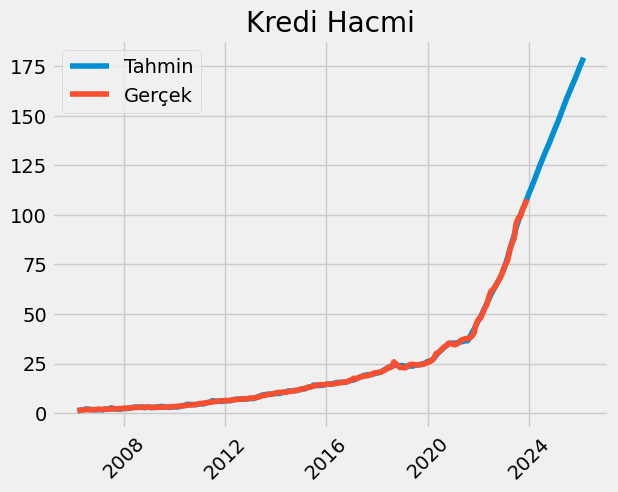

In [111]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df3["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [112]:
kreditahmin=predictions["yhat"].tail(30)
kreditahmin[:3]=df3.iloc[-3:,0]
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi"]
kreditahmin=kreditahmin.set_index(pd.date_range(start="2023-09-30",periods=len(kreditahmin),freq="1M"))
kreditahmin

,Kredi
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144
2023-12-31,110.747146
2024-01-31,113.266284
2024-02-29,115.774377
2024-03-31,118.535650
2024-04-30,121.435407
2024-05-31,124.332913
2024-06-30,126.841730


In [113]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"].index
    sn["y"]=m3["M3 Para Arzi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"].index\n    sn["y"]=m3["M3 Para Arzi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [114]:
#study.best_params

In [115]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"].index
sn["y"]=m3["M3 Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=8.349018793181163,
 changepoint_range=0.9998797288182553,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:20 - cmdstanpy - INFO - Chain [1] start processing


23:07:20 - cmdstanpy - INFO - Chain [1] done processing


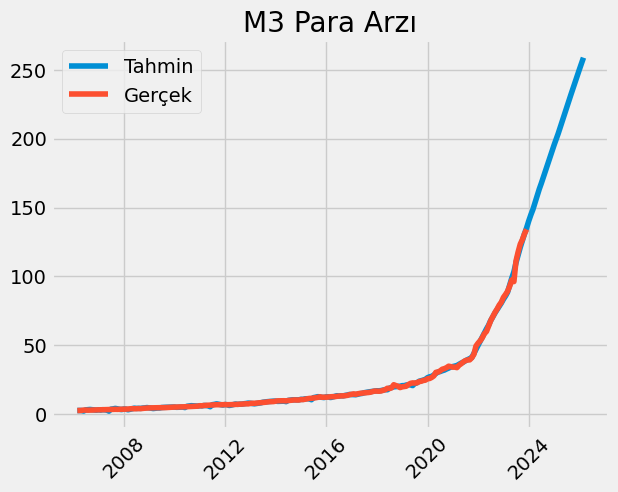

In [116]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(m3["M3 Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [117]:
m3tahmin=predictions["yhat"].tail(30)
m3tahmin[:3]=m3.iloc[-3:,0]
m3tahmin=pd.DataFrame(m3tahmin)
m3tahmin.columns=["M3"]
m3tahmin=m3tahmin.set_index(pd.date_range(start="2023-09-30",periods=len(kreditahmin),freq="1M"))
m3tahmin

,M3
2023-09-30,126.660411
2023-10-31,130.933903
2023-11-30,134.158381
2023-12-31,140.232633
2024-01-31,144.721396
2024-02-29,148.516007
2024-03-31,153.448476
2024-04-30,158.312950
2024-05-31,163.354211
2024-06-30,167.601338


In [118]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [119]:
#study.best_params

In [120]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=9.211536170339631,
 changepoint_range=0.891187110790083,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:21 - cmdstanpy - INFO - Chain [1] start processing
23:07:21 - cmdstanpy - INFO - Chain [1] done processing


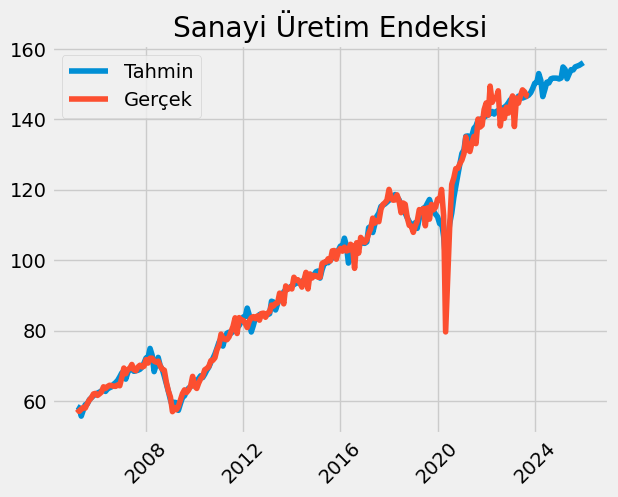

In [121]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [122]:
sanayitahmin=predictions["yhat"].tail(27)
sanayitahmin=pd.DataFrame(sanayitahmin)
sanayitahmin.columns=["Sanayi"]
sanayitahmin=sanayitahmin.set_index(pd.date_range(start="2023-10-31",periods=len(sanayitahmin),freq="1M"))
sanayitahmin

,Sanayi
2023-10-31,147.549780
2023-11-30,148.746355
2023-12-31,150.218248
2024-01-31,150.476348
2024-02-29,152.980863
2024-03-31,151.088129
2024-04-30,146.446123
2024-05-31,148.435360
2024-06-30,150.541376
2024-07-31,150.307142


In [123]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [124]:
#study.best_params

In [125]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=200
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=200
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:22 - cmdstanpy - INFO - Chain [1] start processing
23:07:22 - cmdstanpy - INFO - Chain [1] done processing


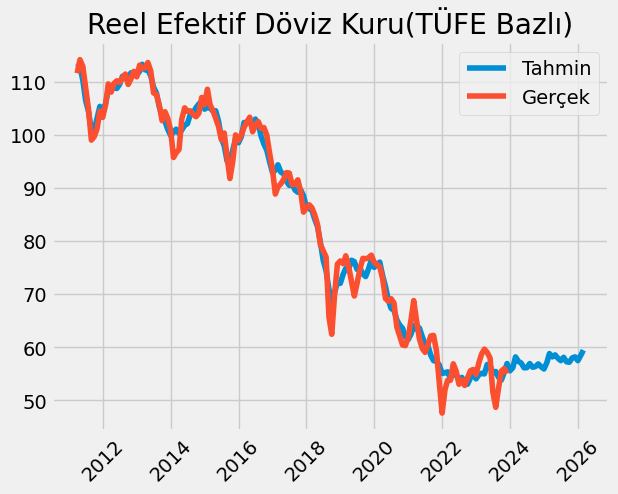

In [126]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [127]:
predictions["yhat"].tail(28)

ds
2023-11-30    56.956422
2023-12-31    55.581356
2024-01-31    56.173216
2024-02-29    58.206784
2024-03-31    57.359178
2024-04-30    57.042268
2024-05-31    56.146748
2024-06-30    56.173367
2024-07-31    56.952786
2024-08-31    56.253677
2024-09-30    56.383799
2024-10-31    56.884394
2024-11-30    56.347050
2024-12-31    55.928696
2025-01-31    57.120511
2025-02-28    58.833627
2025-03-31    58.209589
2025-04-30    58.589592
2025-05-31    57.939096
2025-06-30    57.497557
2025-07-31    58.129325
2025-08-31    57.283044
2025-09-30    57.199000
2025-10-31    58.011290
2025-11-30    58.211523
2025-12-31    57.492700
2026-01-31    58.493375
2026-02-28    59.471924
Name: yhat, dtype: float64

In [128]:
redkttahmin=predictions["yhat"].tail(27)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin

,REDKT
2023-12-31,55.581356
2024-01-31,56.173216
2024-02-29,58.206784
2024-03-31,57.359178
2024-04-30,57.042268
2024-05-31,56.146748
2024-06-30,56.173367
2024-07-31,56.952786
2024-08-31,56.253677
2024-09-30,56.383799


In [129]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic','linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\',\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [130]:
#study.best_params

In [131]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
sn["cap"]=165
prophet=Prophet(changepoint_prior_scale=4.697452368413781,
 changepoint_range=0.9845493532029166,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=165
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:23 - cmdstanpy - INFO - Chain [1] start processing


23:07:23 - cmdstanpy - INFO - Chain [1] done processing


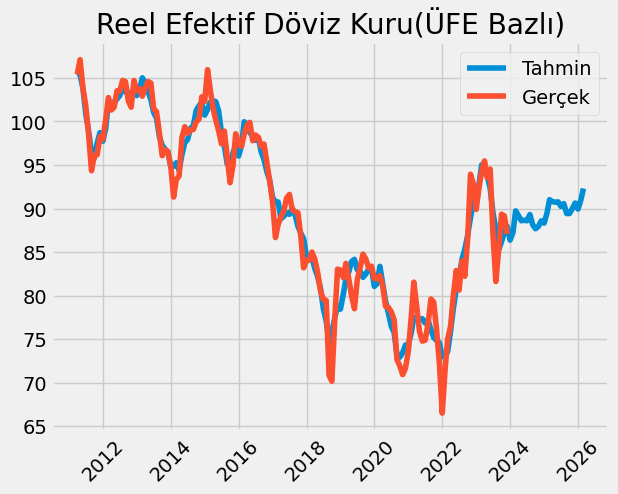

In [132]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [133]:
redktahmin=predictions["yhat"].tail(27)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redktahmin

,REDK
2023-12-31,86.373456
2024-01-31,87.239667
2024-02-29,89.729383
2024-03-31,89.170241
2024-04-30,88.597250
2024-05-31,88.653628
2024-06-30,88.593602
2024-07-31,89.307854
2024-08-31,88.121405
2024-09-30,87.675159


In [134]:
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-5.157893
2024-01-31,-1.070929
2024-02-29,5.494473
2024-03-31,-1.274749
2024-04-30,2.002649
2024-05-31,15.275630
2024-06-30,6.740330
2024-07-31,-0.591019
2024-08-31,-0.280619


In [135]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),paraarzitahmin1["Para Arzi"].shift(1),sanayitahmin["Sanayi"],kreditahmin.rolling(2).mean(),m3tahmin.shift(1),borctahmin1.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende"]=perakendetahmin



tahmindf["Şok"]=0
tahmindf=tahmindf.iloc[:19]
tahmindf["Politika Faizi"]=[40,40,40,40,40,42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40]
tahmindf=tahmindf[['USD/TL', 'Motorin','Perakende', 'Kredi Faizi', 'Zam','Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','Şok','M3','REDKT','REDK','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Perakende Satış","Kredi Faizi","Zam","Sanayi","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Şok','M3','REDKT','REDK','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)





tahmindf.iloc[0,1]=-3.52
tahmindf

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Şok,M3,REDKT,REDK,İşsizlik,Politika Faizi
2023-12-31,2.290664,-3.520000,5.092513,58.050804,0.0,0.989532,4.802205,2.361427,1.883543,2.799611,47.851478,0,2.462676,55.581356,86.373456,9.050290,42.5
2024-01-31,2.184318,-1.070929,1.614187,58.243736,45.0,0.171816,5.029205,2.435868,2.736763,2.470179,48.648966,0,4.527672,56.173216,87.239667,9.065341,45.0
2024-02-29,1.827664,5.494473,5.821133,58.551302,0.0,1.664391,4.548808,2.899538,2.617891,2.244165,48.171069,0,3.200941,58.206784,89.729383,9.121499,45.0
2024-03-31,2.932024,-1.274749,1.644104,59.409785,0.0,-1.237236,4.443607,2.177861,2.666241,2.300625,48.461808,0,2.622011,57.359178,89.170241,9.176342,45.0
2024-04-30,3.049021,2.002649,-10.673696,60.386403,0.0,-3.072383,4.622889,2.761391,2.527586,2.416042,48.499189,0,3.321170,57.042268,88.597250,9.229218,45.0
2024-05-31,3.627961,15.275630,-1.121014,60.370085,0.0,1.358340,4.410014,2.752941,2.671336,2.415818,48.379245,0,3.170103,56.146748,88.653628,9.281954,45.0
2024-06-30,3.024005,6.740330,10.832184,61.813906,0.0,1.418810,4.388893,2.824177,2.764717,2.199764,48.420419,0,3.184364,56.173367,88.593602,9.332391,45.0
2024-07-31,2.888006,-0.591019,0.895907,62.228177,0.0,-0.155594,4.233606,2.229595,2.029508,2.072975,48.444226,0,2.599950,56.952786,89.307854,9.380442,45.0
2024-08-31,2.757106,-0.280619,-1.028484,62.126429,0.0,0.790256,4.137704,2.454751,2.563505,2.092721,48.418841,0,2.797617,56.253677,88.121405,9.426728,45.0
2024-09-30,2.741748,0.296465,-0.804435,62.043374,0.0,0.120596,3.871818,2.258201,2.324508,1.903470,48.421924,0,2.635165,56.383799,87.675159,9.470719,45.0


In [136]:
np.random.seed(42)
tf.random.set_seed(42)
X = data.drop(['TÜFE'], axis=1).values
y = data['TÜFE'].values
X=data[['USD/TL',
 'Motorin',
 'Enflasyon Belirsizliği',
 'ParaArzi','Zam','Kredi','Kredi Faizi','Mevduat Faizi']].values

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(8,1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(1))
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')




model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 1s 10ms/step - loss: 3.4217
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1655
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0177
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0185
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0504
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0482
Epoch 10/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0380
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 12/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0342
Epoch 13/100
4/4 [==============================] - 0s 8ms/s

In [137]:
tahmin=tahmindf[['USD/TL',
 'Motorin',
 'Enflasyon Belirsizliği',
 'ParaArzi','Zam','Kredi','Kredi Faizi','Mevduat Faizi']].values

X_scaled = scaler.fit_transform(X)
tahmin_scaled = scaler.transform(tahmin)

In [138]:
pred = model.predict(tahmin_scaled)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
pred = scaler.inverse_transform(pred)
pred

1/1 [==============================] - 0s 190ms/step


array([[2.9787958],
       [4.479373 ],
       [3.5889392],
       [3.093896 ],
       [3.5061054],
       [4.77327  ],
       [3.8844965],
       [3.1081336],
       [3.1120431],
       [3.0423284],
       [3.4824288],
       [2.8614132],
       [3.0693352],
       [4.123412 ]], dtype=float32)

In [139]:
corr=data.corr()["TÜFE"].sort_values(ascending=False)
np.abs(corr).sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.724721
Motorin                   0.718312
ParaArzi                  0.678612
M3                        0.670119
Enflasyon Belirsizliği    0.622137
REDKT                     0.575371
Kredi Faizi               0.531337
Kredi                     0.520359
Borç                      0.447182
Mevduat Faizi             0.441591
Zam                       0.410035
REDK                      0.391061
Politika Faizi            0.215310
İşsizlik                  0.187390
Perakende Satış           0.116436
Sanayi                    0.047965
Name: TÜFE, dtype: float64

In [140]:
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','REDKT','Kredi Faizi','Borç','Zam','Kredi']
X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1806.50
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-12-31,1850.369365
2024-01-31,1937.827152
2024-02-29,2001.403941
2024-03-31,2055.919430
2024-04-30,2121.623449
2024-05-31,2219.068566
2024-06-30,2300.752163
2024-07-31,2365.744685
2024-08-31,2433.393259
2024-09-30,2502.664766


In [141]:
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','REDKT','Kredi Faizi','Borç','Zam','Kredi']


X= data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1806.50
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-12-31,1845.796579
2024-01-31,1928.077459
2024-02-29,1986.834137
2024-03-31,2035.961130
2024-04-30,2095.927455
2024-05-31,2187.177262
2024-06-30,2262.107898
2024-07-31,2319.880320
2024-08-31,2379.915489
2024-09-30,2441.171187


In [250]:
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','Kredi Faizi','Borç','Zam']


X = data[features]
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X,y)


tüfetahmin5 = []
result = 1806.50
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-12-31,1849.738930
2024-01-31,1936.389468
2024-02-29,1999.746652
2024-03-31,2053.822221
2024-04-30,2119.196615
2024-05-31,2216.289714
2024-06-30,2297.510765
2024-07-31,2361.772062
2024-08-31,2428.586361
2024-09-30,2496.787752


In [251]:
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','Kredi Faizi','Borç','Zam']



X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1806.50
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-12-31,1849.728728
2024-01-31,1936.374253
2024-02-29,1999.718416
2024-03-31,2053.782540
2024-04-30,2119.143368
2024-05-31,2216.217102
2024-06-30,2297.419974
2024-07-31,2361.661906
2024-08-31,2428.457412
2024-09-30,2496.637245


In [144]:
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','REDKT','Kredi Faizi','Borç','Zam','Kredi']

X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1806.50
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-12-31,1849.479144
2024-01-31,1935.834715
2024-02-29,1998.857713
2024-03-31,2052.612504
2024-04-30,2117.605171
2024-05-31,2214.254269
2024-06-30,2295.080417
2024-07-31,2358.972075
2024-08-31,2425.437811
2024-09-30,2493.343112


In [145]:
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','REDKT','Kredi Faizi','Borç','Zam','Kredi']



X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1806.50  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-12-31,1849.482125
2024-01-31,1935.841679
2024-02-29,1998.868042
2024-03-31,2052.626408
2024-04-30,2117.622892
2024-05-31,2214.276484
2024-06-30,2295.107319
2024-07-31,2359.003795
2024-08-31,2425.474677
2024-09-30,2493.385440


In [146]:
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','REDKT','Kredi Faizi','Borç','Zam','Kredi']
X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-12-31,1852.219060
2024-01-31,1943.153658
2024-02-29,2009.368986
2024-03-31,2066.268018
2024-04-30,2134.525410
2024-05-31,2235.676257
2024-06-30,2320.894976
2024-07-31,2389.132465
2024-08-31,2460.381514
2024-09-30,2533.567989


In [388]:
from sklearn import tree
model=tree.DecisionTreeRegressor(splitter='best',max_depth=4)
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','Kredi Faizi','Zam','Borç']
X = data[features]
y=data["TÜFE"]
model.fit(X, y)


tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
treetahmin=model.predict(tahmindf[features])
treetahmin=1+(treetahmin/100)
for elem in treetahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin10.columns=["Decision Tree Regressor"]

tüfetahmin10

,Decision Tree Regressor
2023-12-31,1859.671093
2024-01-31,1914.407182
2024-02-29,1975.388297
2024-03-31,2033.530315
2024-04-30,2098.305952
2024-05-31,2165.144939
2024-06-30,2234.113001
2024-07-31,2299.870117
2024-08-31,2367.562676
2024-09-30,2437.247645


In [301]:
from sklearn.ensemble import GradientBoostingRegressor
model=GradientBoostingRegressor()
features=['USD/TL', 'Motorin','ParaArzi','Enflasyon Belirsizliği','Kredi Faizi','Borç','Zam','Kredi']
X = data[features]
y=data["TÜFE"]
model.fit(X, y)


tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
gradienttahmin=model.predict(tahmindf[features])
gradienttahmin=1+(gradienttahmin/100)
for elem in gradienttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin22.columns=["Gradient Boosting Regressor"]

tüfetahmin22


,Gradient Boosting Regressor
2023-12-31,1845.349439
2024-01-31,1919.296899
2024-02-29,1997.787896
2024-03-31,2038.388423
2024-04-30,2116.346494
2024-05-31,2201.487774
2024-06-30,2288.585581
2024-07-31,2343.251643
2024-08-31,2399.223481
2024-09-30,2455.406877


In [148]:
pred1=pd.DataFrame(pred,index=pd.date_range(start="2023-12-30",periods=14,freq="1M"))
pred1=pred1[0]

In [149]:



tüfetahmin19 = []
result = 1806.50
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin19

,LSTM
2023-12-31,1860.311946
2024-01-31,1943.642256
2024-02-29,2013.398395
2024-03-31,2075.690845
2024-04-30,2148.466755
2024-05-31,2251.018877
2024-06-30,2338.459625
2024-07-31,2411.142073
2024-08-31,2486.177855
2024-09-30,2561.815549


In [389]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["Decision Tree Regressor"]=tüfetahmin10["Decision Tree Regressor"]
tüfetahmin["Gradient Boosting Regressor"]=tüfetahmin22["Gradient Boosting Regressor"]
tüfetahmin["LSTM"]=tüfetahmin19["LSTM"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Decision Tree Regressor,Gradient Boosting Regressor,LSTM,Ortalama
2023-12-31,1850.369365,1845.796579,1849.738930,1849.728728,1849.479144,1849.482125,1852.219060,1859.671093,1845.349439,1860.311946,1851.214641
2024-01-31,1937.827152,1928.077459,1936.389468,1936.374253,1935.834715,1935.841679,1943.153658,1914.407182,1919.296899,1943.642256,1933.084472
2024-02-29,2001.403941,1986.834137,1999.746652,1999.718416,1998.857713,1998.868042,2009.368986,1975.388297,1997.787896,2013.398395,1998.137248
2024-03-31,2055.919430,2035.961130,2053.822221,2053.782540,2052.612504,2052.626408,2066.268018,2033.530315,2038.388423,2075.690845,2051.860183
2024-04-30,2121.623449,2095.927455,2119.196615,2119.143368,2117.605171,2117.622892,2134.525410,2098.305952,2116.346494,2148.466755,2118.876356
2024-05-31,2219.068566,2187.177262,2216.289714,2216.217102,2214.254269,2214.276484,2235.676257,2165.144939,2201.487774,2251.018877,2212.061124
2024-06-30,2300.752163,2262.107898,2297.510765,2297.419974,2295.080417,2295.107319,2320.894976,2234.113001,2288.585581,2338.459625,2293.003172
2024-07-31,2365.744685,2319.880320,2361.772062,2361.661906,2358.972075,2359.003795,2389.132465,2299.870117,2343.251643,2411.142073,2357.043114
2024-08-31,2433.393259,2379.915489,2428.586361,2428.457412,2425.437811,2425.474677,2460.381514,2367.562676,2399.223481,2486.177855,2423.461053
2024-09-30,2502.664766,2441.171187,2496.787752,2496.637245,2493.343112,2493.385440,2533.567989,2437.247645,2455.406877,2561.815549,2491.202756


In [390]:
dates=pd.date_range('2006-02-01','2023-12-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]

dfas11=pd.DataFrame()
dfas11=pd.concat([df["CPI"],tüfetahmin.iloc[1:,9]],axis=0)
dfas11=pd.DataFrame(dfas11)
dfas11.columns=[tüfetahmin.columns[9]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10,dfas11],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [391]:
row=pd.DataFrame({"SGD Regressor":df.iloc[-1,0],"Lasso Regression":df.iloc[-1,0],"Lars Regression":df.iloc[-1,0],"Gaussian Regression":df.iloc[-1,0],"Kernel Regression":df.iloc[-1,0],"Bayessian Regression":df.iloc[-1,0],"Linear Regression":df.iloc[-1,0],"Decision Tree Regressor":df.iloc[-1,0],"Gradient Boosting Regressor":df.iloc[-1,0],"LSTM":df.iloc[-1,0],"Ortalama":df.iloc[-1,0]},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin.iloc[1,:9]=tüfetahmin.iloc[1,:9]+3.5
tüfetahmin.iloc[2:,:9]=tüfetahmin.iloc[2:,:9]+3.08

tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,Decision Tree Regressor,Gradient Boosting Regressor,LSTM,Ortalama
2023-11-30,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000
2023-12-31,1853.869365,1853.238930,1853.228728,1852.982125,1852.979144,1855.719060,1849.296579,1863.171093,1848.849439,1860.311946,1854.078277
2024-01-31,1940.907152,1939.469468,1939.454253,1938.921679,1938.914715,1946.233658,1931.157459,1917.487182,1922.376899,1943.642256,1935.604472
2024-02-29,2004.483941,2002.826652,2002.798416,2001.948042,2001.937713,2012.448986,1989.914137,1978.468297,2000.867896,2013.398395,2000.657248
2024-03-31,2058.999430,2056.902221,2056.862540,2055.706408,2055.692504,2069.348018,2039.041130,2036.610315,2041.468423,2075.690845,2054.380183
2024-04-30,2124.703449,2122.276615,2122.223368,2120.702892,2120.685171,2137.605410,2099.007455,2101.385952,2119.426494,2148.466755,2121.396356
2024-05-31,2222.148566,2219.369714,2219.297102,2217.356484,2217.334269,2238.756257,2190.257262,2168.224939,2204.567774,2251.018877,2214.581124
2024-06-30,2303.832163,2300.590765,2300.499974,2298.187319,2298.160417,2323.974976,2265.187898,2237.193001,2291.665581,2338.459625,2295.523172
2024-07-31,2368.824685,2364.852062,2364.741906,2362.083795,2362.052075,2392.212465,2322.960320,2302.950117,2346.331643,2411.142073,2359.563114
2024-08-31,2436.473259,2431.666361,2431.537412,2428.554677,2428.517811,2463.461514,2382.995489,2370.642676,2402.303481,2486.177855,2425.981053


In [392]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,Decision Tree Regressor,Gradient Boosting Regressor,LSTM,Ortalama
2023-12-31,2.622162,2.587264,2.586700,2.573049,2.572884,2.724554,2.369033,3.137066,2.344281,2.978796,2.633727
2024-01-31,4.694926,4.652964,4.652719,4.637905,4.637698,4.877602,4.426596,2.915250,3.976931,4.479373,4.397128
2024-02-29,3.275622,3.266728,3.266082,3.250588,3.250427,3.402229,3.042563,3.180262,4.083018,3.588939,3.360851
2024-03-31,2.719677,2.699963,2.699429,2.685303,2.685138,2.827353,2.468800,2.938739,2.029146,3.093896,2.685264
2024-04-30,3.191065,3.178294,3.177695,3.161759,3.161595,3.298497,2.940908,3.180561,3.818725,3.506105,3.262112
2024-05-31,4.586293,4.574950,4.574153,4.557621,4.557447,4.731970,4.347284,3.180710,4.017185,4.773270,4.392615
2024-06-30,3.675884,3.659645,3.658946,3.645369,3.645195,3.806521,3.421088,3.180854,3.950788,3.884496,3.654960
2024-07-31,2.821061,2.793252,2.792520,2.780299,2.780122,2.936240,2.550447,2.939269,2.385429,3.108134,2.789775
2024-08-31,2.855786,2.825306,2.824643,2.814078,2.813898,2.978375,2.584425,2.939385,2.385504,3.112043,2.814841
2024-09-30,2.843106,2.804718,2.803980,2.796345,2.796162,2.970880,2.570534,2.939497,2.338730,3.042328,2.792343


In [393]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [308]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [309]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [310]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [311]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [312]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [313]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [314]:
tüfe = 1806.50# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [315]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [394]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin21 = []
treetahmin=aylıktahmin["Decision Tree Regressor"]
treetahmin=1+(treetahmin/100)
for elem in treetahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin21.append(tüfe)
tüfetahmin21=pd.DataFrame(tüfetahmin21)
tüfetahmin21=tüfetahmin21.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin21.columns=["CPI"]
tüfetahmin21=pd.concat([df["CPI"],tüfetahmin21["CPI"]],axis=0)
tüfetahmin21=pd.DataFrame((tüfetahmin21.pct_change(periods=12)*100).tail(38))

In [333]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin23 = []
gradienttahmin=aylıktahmin["Gradient Boosting Regressor"]
gradienttahmin=1+(gradienttahmin/100)
for elem in gradienttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))

In [395]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":3.43},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)
aylık.to_csv('aylık.csv')

In [396]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

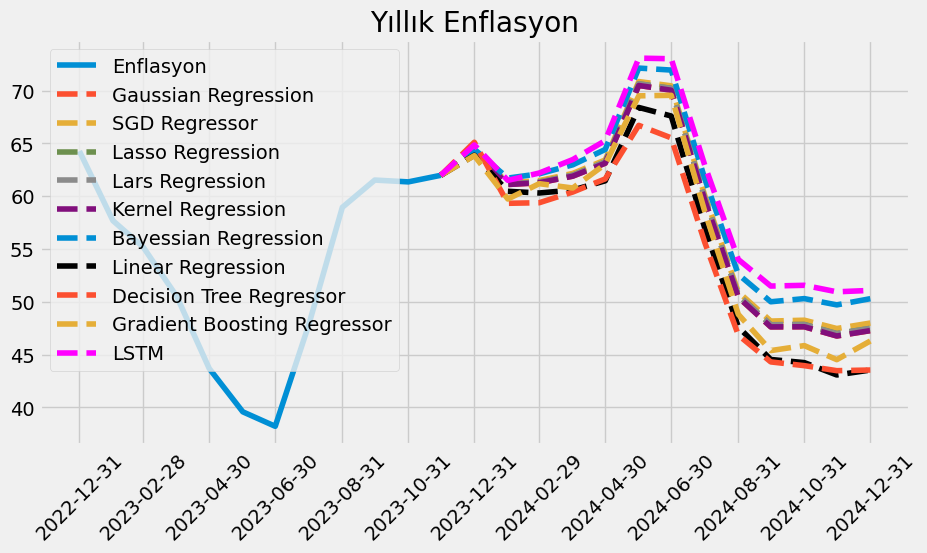

In [397]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Decision Tree Regressor"]=tüfetahmin21["CPI"]
yıllıktahmin["Gradient Boosting Regressor"]=tüfetahmin23["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:-1],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:-1],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:-1],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:-1],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:-1],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:-1],'--',label="Bayessian Regression")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:-1],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["Decision Tree Regressor"].iloc[23:-1],'--',label="Decision Tree Regressor")
plt.plot(yıllıktahmin["Gradient Boosting Regressor"].iloc[23:-1],'--',label="Gradient Boosting Regressor")
plt.plot(yıllıktahmin["LSTM"].iloc[23:-1],'--',label="LSTM",color="magenta")
plt.legend(loc=0)
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [398]:

df.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/df.csv')

In [399]:
yıllıktahmin["Maksimum"]=yıllıktahmin.iloc[:,1:9].max(axis=1)
yıllıktahmin["Minimum"]=yıllıktahmin.iloc[:,1:9].min(axis=1)
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:9].mean(axis=1)
yıllıktahmin.iloc[11:-1].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,Decision Tree Regressor,Gradient Boosting Regressor,LSTM,Maksimum,Minimum
2021-12-31,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494


In [400]:
sonu2023=str(yıllıktahmin.iloc[24,0])[:5]
tepe=str(yıllıktahmin.iloc[29,0])[:5]
sonu2024=str(yıllıktahmin.iloc[36,0])[:5]
max=str(yıllıktahmin.iloc[36,-2])[:5]
min=str(yıllıktahmin.iloc[36,-1])[:5]


In [401]:
min1=str(yıllıktahmin.iloc[36,-1])[:2]
max1=str(yıllıktahmin.iloc[36,-2])[:2]

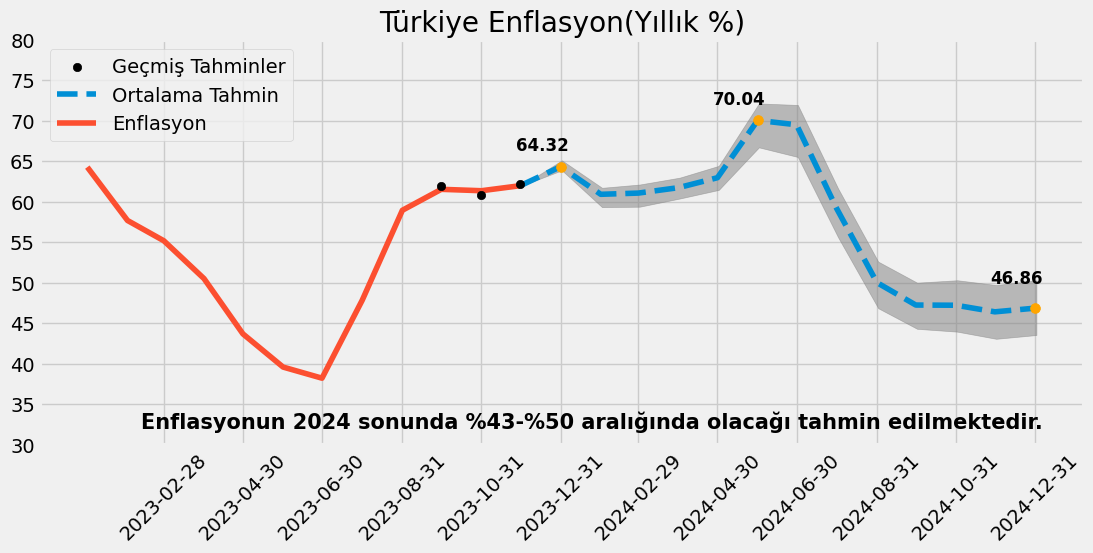

In [402]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(12,5))
plt.scatter(x=yıllıktahmin.index[21:24],y=[61.94,60.84,62.13],color='black',zorder=3,label='Geçmiş Tahminler')
plt.scatter(x=yıllıktahmin.index[24],y=yıllıktahmin.iloc[24,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[29],y=yıllıktahmin.iloc[29,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[23:37],'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.fill_between(yıllıktahmin.iloc[23:39].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[23:39].shift(1), yıllıktahmin["Minimum"].iloc[23:39].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2025-01')
plt.text(mdates.datestr2num('2024-01'), float(sonu2023)+2, sonu2023, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+2, tepe, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+3, sonu2024, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[14:37:2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()
